
# Lab | Clustering songs

## Introduction

Now it's time to cluster the songs of the **hot_songs** and **not_hot_songs** databases according to the song's audio features. For this purpose, you need to consider the following questions:

* Are you going to use all the audio features? I
  * If not, which ones do you think that makes more sense to be used?
  * It might make sense to use a dimensionality reduction technique to visualize the songs with only two features?
* What is the optimal number of clusters (for methods that need to know this beforehand)?
* What is the best distance to use?
* What clustering method provides better results?
* Does the clustering method need a transformer?

## Considerations

Be aware that this process is extremely time-consuming!!! (it might take several hours on your laptop). Therefore, when testing different options, save the models into your disk in order to be able to use the best model later.  You don't want to retrain the best model again when you know what are the optimal parameters for each.

To determine which clustering method performs best, you need to be practical and think about how many clusters you might want to have alongside with a [clustering metric](https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/) to evaluate how good or bad the songs were clustered.
If the number of clusters is small, each cluster will be too big and generic. On the contrary, if the number of clusters is too big then each cluster will be too specific and it will be poorly populated (this also depends on how heterogeneous is your dataset).

On the other hand, when you train your clustering model make sure to concatenate both databases together (ie: **hot_songs** and **not_hot_songs**) before. 
If you don't combine both datasets, the clusters obtained with the **hot_songs** will be different than the ones obtained with the **not_hot_songs**
database even though they might have the same label because they will contain different songs. However, after this, you will not know to which original
dataframe belongs each song. To prevent this problem, before the concatenation you can add a new column named "dataset" with a "flag" to remind yourself in which dataset was included ("Hot", "Not hot")
each song. 

Finally, add a new column to the full dataset **for each clustering method with the cluster membership of each song** 


In [1]:
import sys
import config
from config import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
hot_songs_feat = pd.read_csv('hot_songs_with_feat.csv')
not_hot_songs_feat = pd.read_csv('not_hot_songs_with_feat.csv')

In [3]:
hot_songs_feat["hot_song"]=pd.Series(1, index=hot_songs_feat.index)
hot_songs_feat.head()

,Title,Artists,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.61400,...,0.5050,0.898,67.196,audio_features,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,1
1,All I Want For Christmas Is You,Mariah Carey,7iKRL1F3m4t4dkMponnD0P,0.548,0.871,7,-4.253,1,0.0708,0.00113,...,0.7650,0.640,128.136,audio_features,spotify:track:7iKRL1F3m4t4dkMponnD0P,https://api.spotify.com/v1/tracks/7iKRL1F3m4t4...,https://api.spotify.com/v1/audio-analysis/7iKR...,215653,4,1
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.64300,...,0.0652,0.806,119.705,audio_features,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,1
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.18900,...,0.3550,0.947,107.682,audio_features,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,1
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.57900,...,0.0760,0.888,140.467,audio_features,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,1


In [4]:
not_hot_songs_feat["hot_song"]=pd.Series(0, index=not_hot_songs_feat.index)
not_hot_songs_feat.head()

,Artists,Title,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song
0,Sam Feldt,Post Malone,36orMWv2PgvnzXsd5CJ0yL,0.590,0.642,7,-3.870,1,0.1220,0.0771,...,0.1050,0.651,107.356,audio_features,spotify:track:36orMWv2PgvnzXsd5CJ0yL,https://api.spotify.com/v1/tracks/36orMWv2Pgvn...,https://api.spotify.com/v1/audio-analysis/36or...,174444,4,0
1,Quality Control,100 Racks (Offset feat. Playboi Carti),4T2dHb8XBYHlVj7Dyo1cW9,0.939,0.632,1,-2.978,1,0.1370,0.0606,...,0.1010,0.364,133.979,audio_features,spotify:track:4T2dHb8XBYHlVj7Dyo1cW9,https://api.spotify.com/v1/tracks/4T2dHb8XBYHl...,https://api.spotify.com/v1/audio-analysis/4T2d...,157645,4,0
2,Drake,God's Plan,6DCZcSspjsKoFjzjrWoCdn,0.754,0.449,7,-9.211,1,0.1090,0.0332,...,0.5520,0.357,77.169,audio_features,spotify:track:6DCZcSspjsKoFjzjrWoCdn,https://api.spotify.com/v1/tracks/6DCZcSspjsKo...,https://api.spotify.com/v1/audio-analysis/6DCZ...,198973,4,0
3,Francis and the Lights,May I Have This Dance (Remix),0VaIsQoIQY10uxBrOyZ5cQ,0.784,0.435,8,-9.197,1,0.0647,0.4640,...,0.0913,0.865,90.033,audio_features,spotify:track:0VaIsQoIQY10uxBrOyZ5cQ,https://api.spotify.com/v1/tracks/0VaIsQoIQY10...,https://api.spotify.com/v1/audio-analysis/0VaI...,195356,4,0
4,Future,Trapped In The Sun,6QeUzTuBoasiii8nevDciq,0.701,0.546,6,-5.918,0,0.1330,0.4350,...,0.1880,0.118,151.900,audio_features,spotify:track:6QeUzTuBoasiii8nevDciq,https://api.spotify.com/v1/tracks/6QeUzTuBoasi...,https://api.spotify.com/v1/audio-analysis/6QeU...,201980,4,0


In [5]:
combined_data=pd.concat([hot_songs_feat,not_hot_songs_feat],ignore_index=True)
combined_data.head()

,Title,Artists,id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot_song
0,Rockin' Around The Christmas Tree,Brenda Lee,2EjXfH91m7f8HiJN1yQg97,0.589,0.472,8,-8.749,1,0.0502,0.61400,...,0.5050,0.898,67.196,audio_features,spotify:track:2EjXfH91m7f8HiJN1yQg97,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267,4,1
1,All I Want For Christmas Is You,Mariah Carey,7iKRL1F3m4t4dkMponnD0P,0.548,0.871,7,-4.253,1,0.0708,0.00113,...,0.7650,0.640,128.136,audio_features,spotify:track:7iKRL1F3m4t4dkMponnD0P,https://api.spotify.com/v1/tracks/7iKRL1F3m4t4...,https://api.spotify.com/v1/audio-analysis/7iKR...,215653,4,1
2,Jingle Bell Rock,Bobby Helms,7vQbuQcyTflfCIOu3Uzzya,0.754,0.424,2,-8.463,1,0.0363,0.64300,...,0.0652,0.806,119.705,audio_features,spotify:track:7vQbuQcyTflfCIOu3Uzzya,https://api.spotify.com/v1/tracks/7vQbuQcyTflf...,https://api.spotify.com/v1/audio-analysis/7vQb...,130973,4,1
3,Last Christmas,Wham!,2FRnf9qhLbvw8fu4IBXx78,0.735,0.478,2,-12.472,1,0.0293,0.18900,...,0.3550,0.947,107.682,audio_features,spotify:track:2FRnf9qhLbvw8fu4IBXx78,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960,4,1
4,A Holly Jolly Christmas,Burl Ives,77khP2fIVhSW23NwxrRluh,0.683,0.375,0,-13.056,1,0.0303,0.57900,...,0.0760,0.888,140.467,audio_features,spotify:track:77khP2fIVhSW23NwxrRluh,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533,4,1


In [6]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2590 non-null   object 
 1   Artists           2590 non-null   object 
 2   id                2590 non-null   object 
 3   danceability      2590 non-null   float64
 4   energy            2590 non-null   float64
 5   key               2590 non-null   int64  
 6   loudness          2590 non-null   float64
 7   mode              2590 non-null   int64  
 8   speechiness       2590 non-null   float64
 9   acousticness      2590 non-null   float64
 10  instrumentalness  2590 non-null   float64
 11  liveness          2590 non-null   float64
 12  valence           2590 non-null   float64
 13  tempo             2590 non-null   float64
 14  type              2590 non-null   object 
 15  uri               2590 non-null   object 
 16  track_href        2590 non-null   object 


In [7]:
features=combined_data.select_dtypes(exclude=[object])
features.drop('hot_song', axis=1, inplace=True)

In [8]:
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.589,0.472,8,-8.749,1,0.0502,0.61400,0.000000,0.5050,0.898,67.196,126267,4
1,0.548,0.871,7,-4.253,1,0.0708,0.00113,0.000000,0.7650,0.640,128.136,215653,4
2,0.754,0.424,2,-8.463,1,0.0363,0.64300,0.000000,0.0652,0.806,119.705,130973,4
3,0.735,0.478,2,-12.472,1,0.0293,0.18900,0.000002,0.3550,0.947,107.682,262960,4
4,0.683,0.375,0,-13.056,1,0.0303,0.57900,0.000000,0.0760,0.888,140.467,135533,4


In [9]:
columns_to_drop = ['liveness', 'duration_ms', 'time_signature']
features.drop(columns=columns_to_drop, inplace=True)

In [10]:
features.shape

(2590, 10)

In [11]:
from sklearn.preprocessing import StandardScaler
features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
count,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000
mean,0.652459,0.623041,5.091506,-6.932478,0.604247,0.138012,0.229500,0.019191,0.466081,121.976825
std,0.155780,0.180596,3.652294,2.912992,0.489106,0.128914,0.259990,0.103879,0.224355,29.739634
min,0.074600,0.006320,0.000000,-31.160000,0.000000,0.024700,0.000008,0.000000,0.026200,40.319000
25%,0.550250,0.514000,1.000000,-8.209000,0.000000,0.042800,0.030100,0.000000,0.288250,96.494500
50%,0.661500,0.637500,5.000000,-6.493000,1.000000,0.077200,0.123500,0.000000,0.458000,123.031500
75%,0.768000,0.756750,8.000000,-4.959750,1.000000,0.207750,0.341750,0.000051,0.635000,143.968250
max,0.980000,0.996000,11.000000,0.347000,1.000000,0.920000,0.995000,0.964000,0.981000,205.945000


In [12]:
import pickle

scaler = StandardScaler()
scaler.fit(features)
X_scaled = scaler.transform(features)
filename = "feature_scaler.pickle" # Path with filename

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = features.columns)
display(features)
print()
display(X_scaled_df)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,0.589,0.472,8,-8.749,1,0.0502,0.61400,0.000000,0.898,67.196
1,0.548,0.871,7,-4.253,1,0.0708,0.00113,0.000000,0.640,128.136
2,0.754,0.424,2,-8.463,1,0.0363,0.64300,0.000000,0.806,119.705
3,0.735,0.478,2,-12.472,1,0.0293,0.18900,0.000002,0.947,107.682
4,0.683,0.375,0,-13.056,1,0.0303,0.57900,0.000000,0.888,140.467


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,-0.407441,-0.836509,0.796501,-0.623714,0.809291,-0.681300,1.479188,-0.184779,1.925533,-1.842370
1,-0.670683,1.373271,0.522648,0.920015,0.809291,-0.521473,-0.878551,-0.184779,0.775347,0.207143
2,0.651949,-1.102347,-0.846619,-0.525514,0.809291,-0.789145,1.590752,-0.184779,1.515389,-0.076405
3,0.529959,-0.803279,-0.846619,-1.902028,0.809291,-0.843456,-0.155807,-0.184755,2.143979,-0.480759
4,0.196090,-1.373724,-1.394326,-2.102548,0.809291,-0.835697,1.344541,-0.184779,1.880952,0.621855


In [13]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled_df)
principal_components = pca.transform(X_scaled_df)
principal_components_df = pd.DataFrame(principal_components, 
                                       columns=['PCA_'+ str(i) for i in range(1,X_scaled_df.shape[1]+1)])
principal_components_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,1.218014,0.068704,-0.265196,-2.739599,1.508222,-0.429998,-0.668810,0.388727,0.145342,-0.435053
1,-1.702691,-1.237677,-0.441476,-0.178787,0.338673,-0.606331,-0.733811,0.232126,0.311392,0.051964
2,1.101943,-0.182246,1.295632,-1.502865,1.524487,-0.435557,0.898944,-0.311104,-0.303388,-0.286803
3,0.761456,-0.148518,1.284405,-1.562812,1.677271,0.178991,0.505575,-0.435590,1.873321,0.138705
4,1.924628,-0.289574,1.734374,-0.998830,2.006428,-0.673621,1.409603,-0.144658,1.048015,0.175666


In [14]:
print(pca.explained_variance_ratio_)

[0.25752271 0.1296812  0.11693972 0.10575414 0.0926355  0.09003496
 0.07579357 0.07140848 0.04161688 0.01861283]


In [15]:
cumulated_explained_variance_ratio = [sum(pca.explained_variance_ratio_[0:i+1]) for i,value in enumerate(pca.explained_variance_ratio_)]
cumulated_explained_variance_ratio

[0.2575227082236785,
 0.3872039045415935,
 0.5041436226605074,
 0.6098977653992909,
 0.7025332615479798,
 0.7925682259233419,
 0.8683618007059091,
 0.9397702855079526,
 0.9813871651323818,
 1.0]

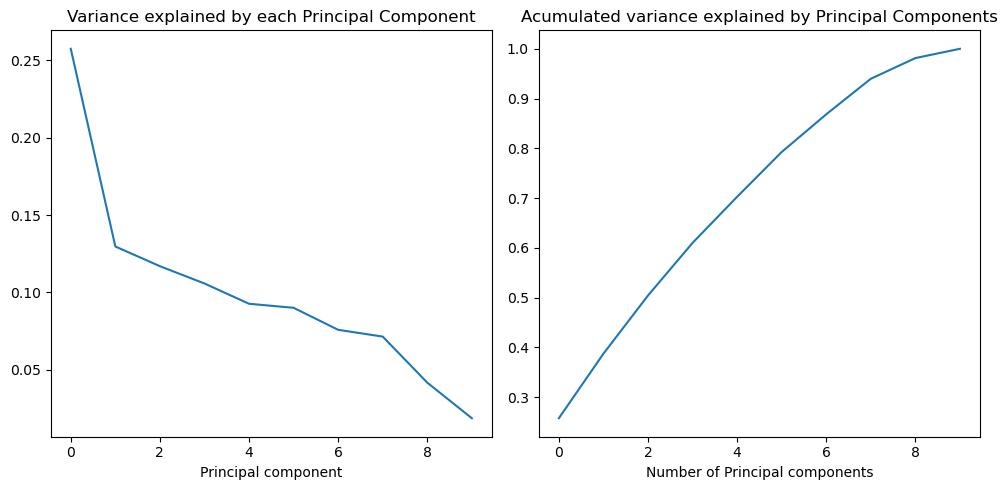

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_xlabel("Principal component")
ax[0].set_title("Variance explained by each Principal Component")
ax[1].plot(cumulated_explained_variance_ratio)
ax[1].set_title("Acumulated variance explained by Principal Components")
ax[1].set_xlabel("Number of Principal components")
plt.tight_layout()
plt.show()

The PCA look pretty grim... we'd have to use 9 columns to explain 80% of the data

##### Trying ISOMAP:

In [17]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=12, n_components=2)
iso.fit(features)
X_isomap_transformed = iso.transform(features)
X_isomap_transformed_df = pd.DataFrame(X_isomap_transformed, columns=["ISO_1","ISO_2"])
X_isomap_transformed_df.head()

,ISO_1,ISO_2
0,-61.046088,0.995589
1,7.564637,-3.056384
2,-2.460613,3.817904
3,-16.760730,4.512814
4,20.801687,6.494922


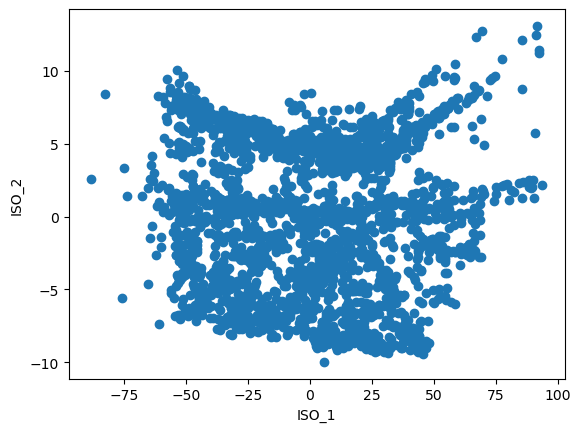

In [18]:
fig, ax = plt.subplots()
ax.scatter(X_isomap_transformed_df['ISO_1'],X_isomap_transformed_df['ISO_2'])
ax.set_xlabel("ISO_1")
ax.set_ylabel("ISO_2")
plt.show()

##### Trying UMAP:

In [41]:
from umap import UMAP

reducer = UMAP(n_components=2,random_state=42)
reducer.fit(features.iloc[:,:-1])

display(features.iloc[:,:-1].head())
X_umap_transformed = reducer.transform(features.iloc[:,:-1])
X_umap_transformed_df = pd.DataFrame(X_umap_transformed, columns=["UMAP_1","UMAP_2"])
display(X_umap_transformed_df.head())

filename = "umap.pickle" # Path with filename # kmeans_n.pickle
with open(filename, "wb") as file:
    pickle.dump(reducer,file)

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,0.589,0.472,8,-8.749,1,0.0502,0.61400,0.000000,0.898,67.196
1,0.548,0.871,7,-4.253,1,0.0708,0.00113,0.000000,0.640,128.136
2,0.754,0.424,2,-8.463,1,0.0363,0.64300,0.000000,0.806,119.705
3,0.735,0.478,2,-12.472,1,0.0293,0.18900,0.000002,0.947,107.682
4,0.683,0.375,0,-13.056,1,0.0303,0.57900,0.000000,0.888,140.467


,UMAP_1,UMAP_2
0,-4.358989,11.873200
1,7.641131,-3.449520
2,3.536043,-2.184105
3,-0.576040,-1.190000
4,9.672899,0.747108


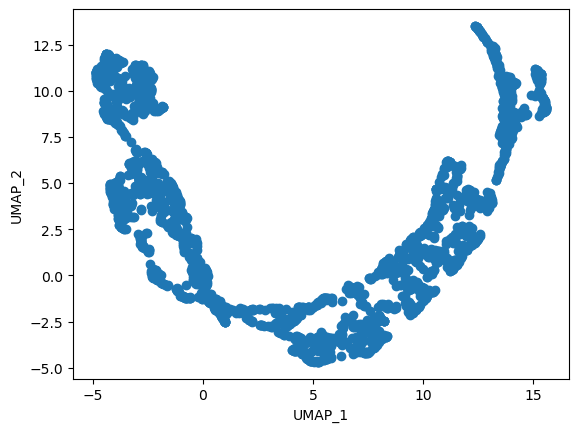

In [18]:
fig, ax = plt.subplots()
ax.scatter(X_umap_transformed_df['UMAP_1'],X_umap_transformed_df['UMAP_2'])
ax.set_xlabel("UMAP_1")
ax.set_ylabel("UMAP_2")
plt.show()

Training a K-Means model with 2 clusters! 

Initialization complete
Iteration 0, inertia 40809.071893452536.
Iteration 1, inertia 23892.458751258022.
Iteration 2, inertia 23738.507690046936.
Iteration 3, inertia 23507.711271728665.
Iteration 4, inertia 23184.532254053098.
Iteration 5, inertia 22910.37784702247.
Iteration 6, inertia 22537.028394484987.
Iteration 7, inertia 22202.45195683569.
Iteration 8, inertia 21980.649014333398.
Iteration 9, inertia 21829.28446828991.
Iteration 10, inertia 21730.329712371724.
Iteration 11, inertia 21660.209678772484.
Iteration 12, inertia 21619.630449934495.
Iteration 13, inertia 21601.920997411853.
Iteration 14, inertia 21597.621604814565.
Iteration 15, inertia 21596.371768357567.
Iteration 16, inertia 21595.958535598522.
Iteration 17, inertia 21595.71712609483.
Iteration 18, inertia 21595.6407896795.
Converged at iteration 18: center shift 9.057229441539697e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 313

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 4 clusters! 

Initialization complete
Iteration 0, inertia 29576.26946292099.
Iteration 1, inertia 18494.231758570582.
Iteration 2, inertia 18236.774389865113.
Iteration 3, inertia 18076.78589471414.
Iteration 4, inertia 18001.36557673651.
Iteration 5, inertia 17992.721333389807.
Iteration 6, inertia 17991.3460195214.
Iteration 7, inertia 17990.42915766882.
Iteration 8, inertia 17989.63097735381.
Iteration 9, inertia 17988.71832733465.
Iteration 10, inertia 17988.405755380834.
Iteration 11, inertia 17988.21925302602.
Iteration 12, inertia 17988.121377612635.
Iteration 13, inertia 17987.94349176283.
Iteration 14, inertia 17987.796208583477.
Iteration 15, inertia 17987.627027431303.
Converged at iteration 15: center shift 3.827437409274808e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 27110.25082329558.
Iteration 1, inertia 19546.385542936932.
Iteration 2, inertia 18763.628264158233.
Iteration 3, inertia 18201.88993

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 12, inertia 16471.028518934447.
Iteration 13, inertia 16469.43060859757.
Iteration 14, inertia 16466.474059332075.
Iteration 15, inertia 16463.382473799236.
Iteration 16, inertia 16461.227516036466.
Iteration 17, inertia 16460.43060112941.
Iteration 18, inertia 16459.697023040666.
Iteration 19, inertia 16459.501844854214.
Iteration 20, inertia 16459.16871486357.
Converged at iteration 20: center shift 9.240938734863207e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 26349.012337337084.
Iteration 1, inertia 19392.503780341733.
Iteration 2, inertia 18532.043196638017.
Iteration 3, inertia 18102.15022302974.
Iteration 4, inertia 17863.955261238032.
Iteration 5, inertia 17750.308272694263.
Iteration 6, inertia 17685.20856655319.
Iteration 7, inertia 17622.0923103548.
Iteration 8, inertia 17550.560300293568.
Iteration 9, inertia 17488.582795504466.
Iteration 10, inertia 17451.908750118688.
Iteration 11, inertia 17432.139144658428.
Iteration

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 7 clusters! 

Initialization complete
Iteration 0, inertia 23609.117898997556.
Iteration 1, inertia 16962.158593211145.
Iteration 2, inertia 16405.60061239972.
Iteration 3, inertia 16010.89777367595.
Iteration 4, inertia 15416.402321752646.
Iteration 5, inertia 14868.519376829574.
Iteration 6, inertia 14767.959474894284.
Iteration 7, inertia 14741.983142606701.
Iteration 8, inertia 14727.305774540942.
Iteration 9, inertia 14716.430299068306.
Iteration 10, inertia 14706.380690554368.
Iteration 11, inertia 14696.575737629915.
Iteration 12, inertia 14689.0131906879.
Iteration 13, inertia 14681.405464392306.
Iteration 14, inertia 14672.698415611412.
Iteration 15, inertia 14666.61414289246.
Iteration 16, inertia 14659.892992918374.
Iteration 17, inertia 14653.505702397713.
Iteration 18, inertia 14648.54770181129.
Iteration 19, inertia 14645.585625821848.
Iteration 20, inertia 14642.624739315454.
Iteration 21, inertia 14638.348869988338.
Iteration 22, inertia 14

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 19, inertia 14350.935619369855.
Iteration 20, inertia 14350.470066468533.
Iteration 21, inertia 14350.340347448564.
Converged at iteration 21: center shift 5.1378362141699666e-05 within tolerance 9.999999999999954e-05.
Initialization complete
Iteration 0, inertia 19230.222549037713.
Iteration 1, inertia 15061.575143086598.
Iteration 2, inertia 14589.524362929173.
Iteration 3, inertia 14462.257458698323.
Iteration 4, inertia 14412.514829909818.
Iteration 5, inertia 14364.968851522877.
Iteration 6, inertia 14308.740184741386.
Iteration 7, inertia 14264.788629097591.
Iteration 8, inertia 14238.454931976463.
Iteration 9, inertia 14216.1951611574.
Iteration 10, inertia 14200.934310087418.
Iteration 11, inertia 14191.96363765393.
Iteration 12, inertia 14181.799364537726.
Iteration 13, inertia 14172.28912529582.
Iteration 14, inertia 14165.472178899528.
Iteration 15, inertia 14158.718543551526.
Iteration 16, inertia 14153.133128885482.
Iteration 17, inertia 14149.5000040715.
Iterati

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 11 clusters! 

Initialization complete
Iteration 0, inertia 17958.470960090137.
Iteration 1, inertia 13530.065419569457.
Iteration 2, inertia 13289.954570762762.
Iteration 3, inertia 13183.355476566441.
Iteration 4, inertia 13106.823044641751.
Iteration 5, inertia 13043.280036880558.
Iteration 6, inertia 13004.796875354474.
Iteration 7, inertia 12969.807782783426.
Iteration 8, inertia 12950.475678962735.
Iteration 9, inertia 12932.570506759148.
Iteration 10, inertia 12915.53433280512.
Iteration 11, inertia 12897.666605358707.
Iteration 12, inertia 12871.50471204961.
Iteration 13, inertia 12849.53175521313.
Iteration 14, inertia 12828.93946452915.
Iteration 15, inertia 12812.403018622397.
Iteration 16, inertia 12800.889578269846.
Iteration 17, inertia 12794.670071061446.
Iteration 18, inertia 12791.028976472833.
Iteration 19, inertia 12787.937988939086.
Iteration 20, inertia 12784.14482838799.
Iteration 21, inertia 12781.349745837144.
Iteration 22, inertia 

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

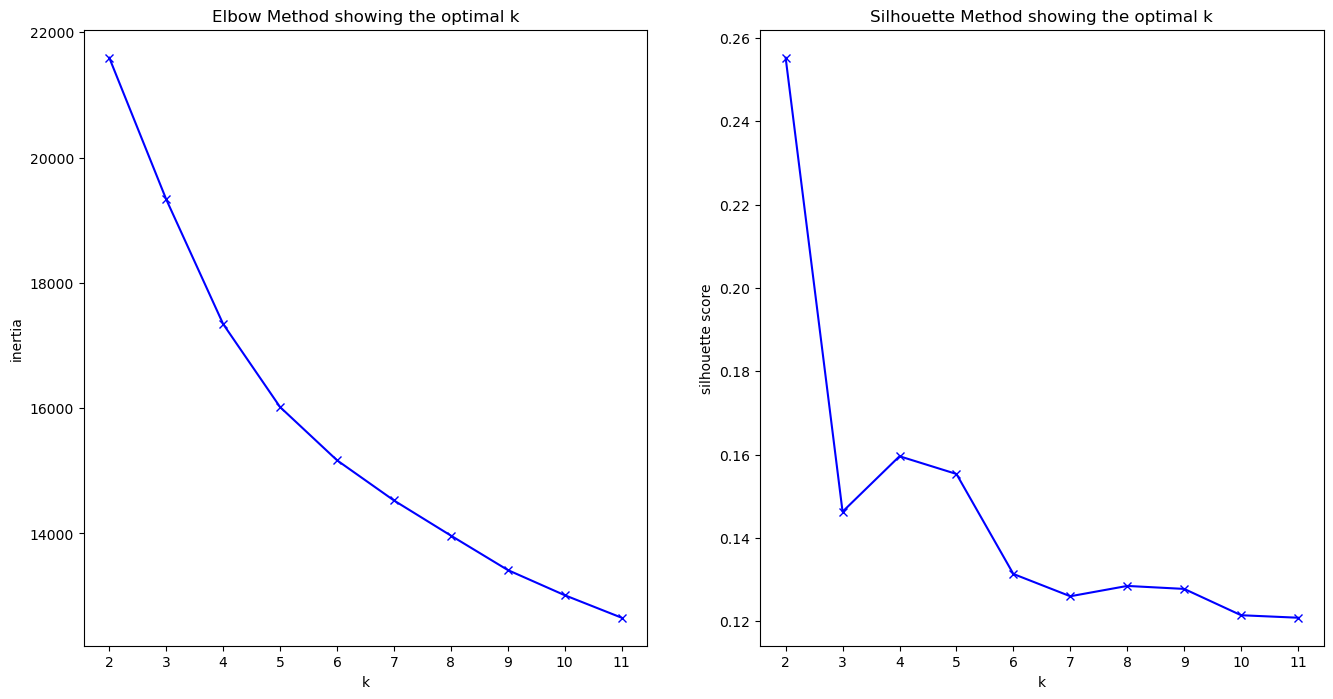

In [24]:
K = range(2, 12)

inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)

    filename = "kmeans_" + str(k) + ".pickle" # Path with filename # kmeans_n.pickle
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

### Kmeans with ISO

In [20]:
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_isomap_transformed_df)

NameError: name 'X_isomap_transformed_df' is not defined

In [33]:
clusters = kmeans.predict(X_isomap_transformed_df)
pd.Series(clusters).value_counts().sort_index() 

0    103
1    446
2    497
3    519
4    374
5    314
6    337
Name: count, dtype: int64

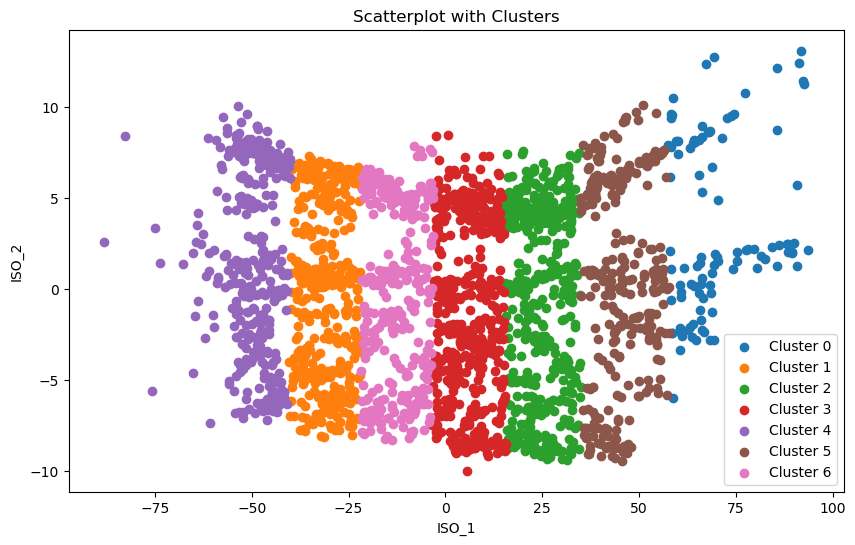

In [34]:
import matplotlib.pyplot as plt

X_isomap_transformed_df['Cluster'] = clusters


plt.figure(figsize=(10, 6))
for cluster in range(7):
    cluster_data = X_isomap_transformed_df[X_isomap_transformed_df['Cluster'] == cluster]
    plt.scatter(cluster_data['ISO_1'], cluster_data['ISO_2'], label=f'Cluster {cluster}')

plt.xlabel('ISO_1')
plt.ylabel('ISO_2')
plt.title('Scatterplot with Clusters')
plt.legend()
plt.show()

### Kmeans with UMAP

In [43]:
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_umap_transformed_df)

display(X_umap_transformed_df)
filename = "kmeans.pickle" # Path with filename # kmeans_n.pickle
with open(filename, "wb") as file:
    pickle.dump(kmeans,file)

C:\Users\vikto\anaconda3\envs\base_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,UMAP_1,UMAP_2
0,-4.358989,11.873200
1,7.641131,-3.449520
2,3.536043,-2.184105
3,-0.576040,-1.190000
4,9.672899,0.747108
...,...,...
2585,13.506151,6.049903
2586,5.512091,-4.340742
2587,10.476321,3.550018
2588,-1.202470,2.194766


In [23]:
clusters = kmeans.predict(X_umap_transformed_df)
pd.Series(clusters).value_counts().sort_index() 

0    382
1    349
2    283
3    342
4    469
5    324
6    441
Name: count, dtype: int64

IndentationError: unexpected indent (3672859126.py, line 2)

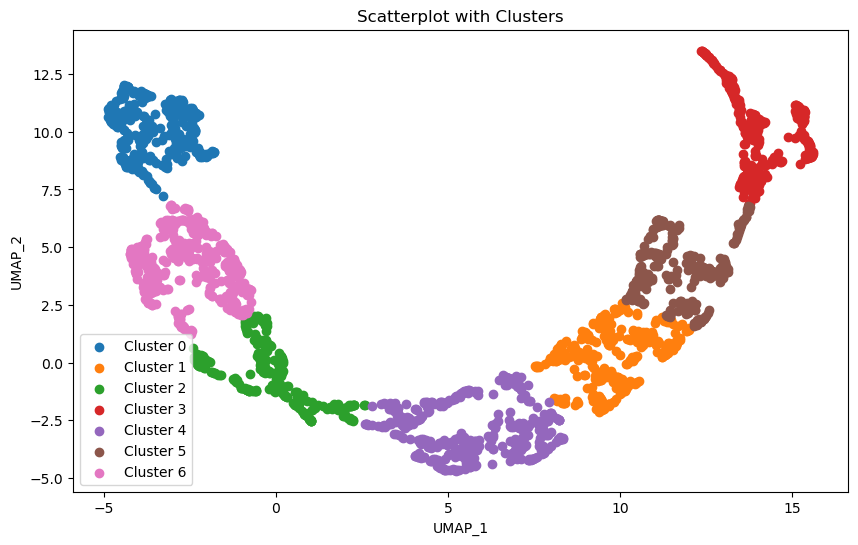

In [24]:
import matplotlib.pyplot as plt

X_umap_transformed_df['Cluster'] = clusters


plt.figure(figsize=(10, 6))
for cluster in range(7):
    cluster_data = X_umap_transformed_df[X_umap_transformed_df['Cluster'] == cluster]
    plt.scatter(cluster_data['UMAP_1'], cluster_data['UMAP_2'], label=f'Cluster {cluster}')

plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.title('Scatterplot with Clusters')
plt.legend()
plt.show()

In [29]:
combined_data['cluster'] = X_umap_transformed_df['Cluster']

In [31]:
combined_data.to_csv('data_clusters.csv', index=False)

In [46]:
kmeans.inertia_

7442.168425134718

### DBSCAN with UMAP


In [38]:

from sklearn.cluster import DBSCAN

In [39]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_umap_transformed_df)
X_scaled_np = scaler.transform(X_umap_transformed_df)
X_scaled_df = pd.DataFrame(X_scaled_np, columns=X_umap_transformed_df.columns)

# Creating the clustering model
model = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_df) # .fit(X_scaled_df)

In [40]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_df, model.fit_predict(X_scaled_df)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_df, model.fit_predict(X_scaled_df)),2))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [41]:
X_umap_transformed_df['dbscan_clusters'] = yhat
X_umap_transformed_df.head()

,UMAP_1,UMAP_2,dbscan_clusters
0,-4.358989,11.873200,0
1,7.641131,-3.449520,0
2,3.536043,-2.184105,0
3,-0.576040,-1.190000,0
4,9.672899,0.747108,0


In [42]:
# retrieve unique clusters
clusters = np.unique(yhat)
clusters # DBSCAN flags with "-1" noisy data.

array([0], dtype=int64)

In [30]:
[cluster for cluster in list(clusters) if cluster != -1]

[0]

### DBSCAN with UMAP

In [ ]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_isomap_transformed_df)
X_scaled_np = scaler.transform(X_isomap_transformed_df)
X_scaled_df = pd.DataFrame(X_scaled_np, columns=X_isomap_transformed_df.columns)

# Creating the clustering model
model = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_df) # .fit(X_scaled_df)

### HDBSCAN with ISOMAP

In [33]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [34]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_isomap_transformed_df)
X_scaled_np = scaler.transform(X_isomap_transformed_df)
X_scaled_df = pd.DataFrame(X_scaled_np, columns=X_isomap_transformed_df.columns)

# Creating the clustering model
model = HDBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_df) # .fit(X_scaled_df)

In [35]:
print("The Silhouette score of the model is: ",round(silhouette_score(X_scaled_df, model.fit_predict(X_scaled_df)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(X_scaled_df, model.fit_predict(X_scaled_df)),2))

The Silhouette score of the model is:  -0.04
The Calinksi-Harabasz score of the model is:  36.76


In [36]:
X_isomap_transformed_df['cluster'] = yhat
X_isomap_transformed_df.head()

,ISO_1,ISO_2,cluster
0,-61.046088,0.995589,-1
1,7.564637,-3.056384,-1
2,-2.460613,3.817904,21
3,-16.760730,4.512814,-1
4,20.801687,6.494922,-1


In [37]:
# retrieve unique clusters
clusters = np.unique(yhat)
clusters # DBSCAN flags with "-1" noisy data.

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104], dtype=int64)

In [26]:
[cluster for cluster in list(clusters) if cluster != -1]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104]

In [27]:
clusters.size - 1

105